In [79]:
from collections import Counter
import pandas as pd
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

stop = set(stopwords.words("russian"))

def remove_stop_words(text):
    text = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(text)

messages = pd.read_csv("messages.csv", encoding="utf-8")
messages = messages[["id", "text"]]
messages.head()

labels = pd.read_csv("labels.csv", encoding="utf-8")
labels = labels[["id","label"]]
labels['label'] = labels['label'].map({'other': 0, 'task': 1, 'event':2})
print(labels.head())

messages["text"] = messages["text"].map(remove_stop_words)

def counter_words(text):
    count = Counter()
    for i in text.values:
        for word in i.split():
            count[word] += 1
    return count


counter = counter_words(messages.text)

     id  label
0  2092      0
1  8104      0
2  5821      0
3  8030      0
4  6966      0


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/taranyuriy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [80]:
num_words = len(counter)
max_length = 20

train_size = int(messages.shape[0] * 0.8)

train_sentences = messages.text[:train_size]
train_labels = labels.label[:train_size]

test_sentences = messages.text[train_size:]
test_labels = labels.label[train_size:]

In [81]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(train_sentences)

word_index = tokenizer.word_index

In [82]:
word_index

{'это': 1,
 'https': 2,
 'нужно': 3,
 'ещ': 4,
 'привет': 5,
 'т': 6,
 'пока': 7,
 'ru': 8,
 'просто': 9,
 'itmo': 10,
 'спасибо': 11,
 'время': 12,
 'также': 13,
 'com': 14,
 'всем': 15,
 'м': 16,
 'd': 17,
 'ису': 18,
 'сегодня': 19,
 'zoom': 20,
 'завтра': 21,
 'июля': 22,
 'день': 23,
 'us': 24,
 'deeppavlov': 25,
 'итмо': 26,
 'сделать': 27,
 'будут': 28,
 'u': 29,
 'нам': 30,
 'студенты': 31,
 'очень': 32,
 'данных': 33,
 'приглашаем': 34,
 'которые': 35,
 'задачи': 36,
 'работы': 37,
 'необходимо': 38,
 'поэтому': 39,
 'j': 40,
 'какие': 41,
 'вопросы': 42,
 'вс': 43,
 'пользователя': 44,
 'д': 45,
 'года': 46,
 'пожалуйста': 47,
 'данные': 48,
 'понял': 49,
 'например': 50,
 'чат': 51,
 'рождения': 52,
 'могу': 53,
 'коллеги': 54,
 'вроде': 55,
 'можете': 56,
 'тебе': 57,
 'делать': 58,
 'думаю': 59,
 'можем': 60,
 'аватар': 61,
 'добрый': 62,
 'уважаемые': 63,
 'вопрос': 64,
 'the': 65,
 'информация': 66,
 'прошу': 67,
 'офис': 68,
 's': 69,
 'олег': 70,
 'c': 71,
 'основе': 7

In [83]:
train_sequense = tokenizer.texts_to_sequences(train_sentences)
test_sequence = tokenizer.texts_to_sequences(test_sentences)

In [84]:
from keras.preprocessing.sequence import pad_sequences

train_padded = pad_sequences(train_sequense, maxlen=max_length, padding="post", truncating="post")
test_padded = pad_sequences(test_sequence, maxlen=max_length, padding="post", truncating="post")

In [89]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.initializers import Constant
from keras.optimizers import Adam
import tensorflow as tf

model = Sequential()
model.add(Embedding(num_words, 32, input_length=max_length))
model.add(LSTM(64, dropout=0.1))
model.add(Dense(3, activation='softmax'))

optimizer = Adam(learning_rate=3e-4)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 20, 32)            749216    
                                                                 
 lstm_12 (LSTM)              (None, 64)                24832     
                                                                 
 dense_12 (Dense)            (None, 3)                 195       
                                                                 
Total params: 774243 (2.95 MB)
Trainable params: 774243 (2.95 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [94]:

history = model.fit(
    train_padded, train_labels, epochs=5, validation_data=(test_padded, test_labels)
)

Epoch 1/5
210/210 [==============================] - 2s 7ms/step - loss: 0.0071 - accuracy: 0.9978 - val_loss: 0.3553 - val_accuracy: 0.9151
Epoch 2/5
210/210 [==============================] - 1s 7ms/step - loss: 0.0052 - accuracy: 0.9982 - val_loss: 0.3804 - val_accuracy: 0.9229
Epoch 3/5
210/210 [==============================] - 2s 7ms/step - loss: 0.0043 - accuracy: 0.9988 - val_loss: 0.3833 - val_accuracy: 0.9187
Epoch 4/5
210/210 [==============================] - 1s 7ms/step - loss: 0.0049 - accuracy: 0.9982 - val_loss: 0.3669 - val_accuracy: 0.9289
Epoch 5/5
210/210 [==============================] - 1s 7ms/step - loss: 0.0037 - accuracy: 0.9987 - val_loss: 0.4219 - val_accuracy: 0.9247


In [95]:
test_loss, test_acc = model.evaluate(test_padded, test_labels)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

53/53 [==============================] - 0s 1ms/step - loss: 0.4219 - accuracy: 0.9247
Test Loss: 0.4218541383743286
Test Accuracy: 0.9246861934661865


(0.0, 0.4427637615124695)

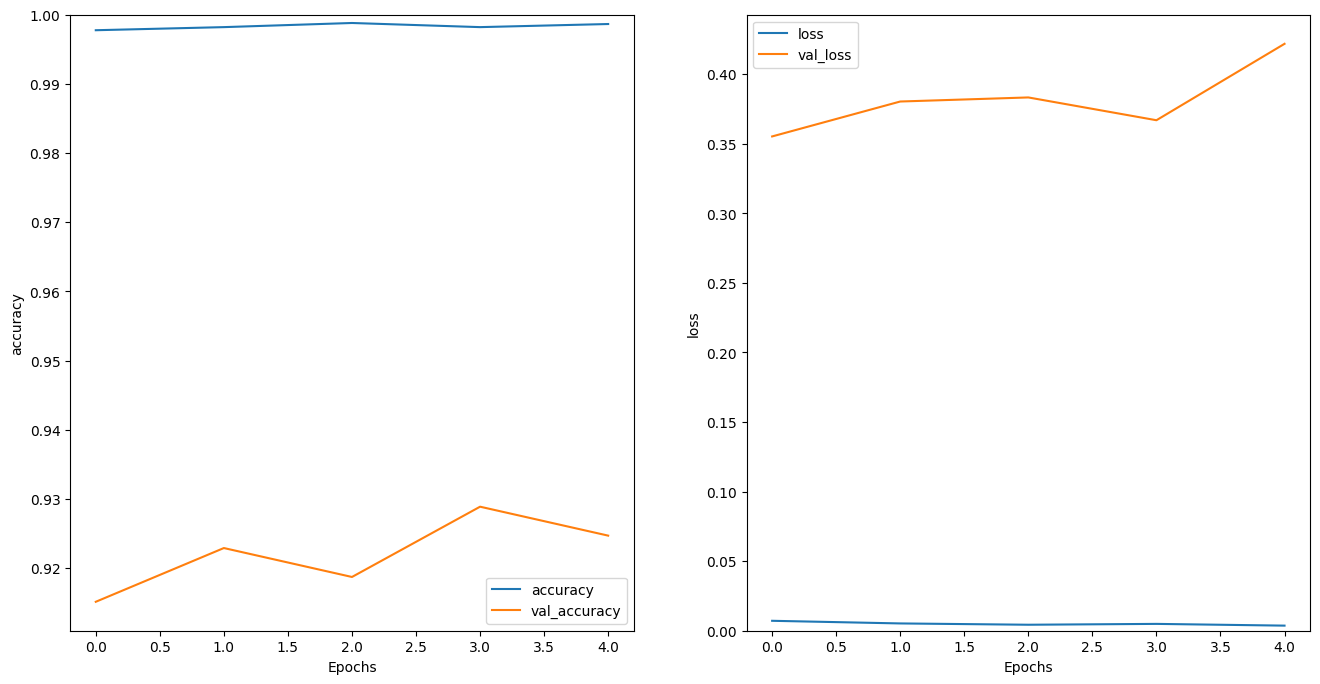

In [96]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)